In [18]:
import pandas as pd
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
from scipy import stats

In [19]:
%matplotlib inline
register_matplotlib_converters()
warnings.filterwarnings('ignore')

In [20]:
df = pd.read_csv("coinbaseUSD.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')    #convert timestamp to date
df.set_index(["Timestamp"], inplace= True)
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2014-12-01 05:33:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2014-12-01 05:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-01 05:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-01 05:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-01 05:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df = df[["Close"]]
df

,Close
Timestamp,
2014-12-01 05:33:00,300.00
2014-12-01 05:34:00,NaN
2014-12-01 05:35:00,NaN
2014-12-01 05:36:00,NaN
2014-12-01 05:37:00,NaN
...,...
2019-01-07 22:02:00,4006.01
2019-01-07 22:03:00,4006.01
2019-01-07 22:04:00,4006.01


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2099760 entries, 2014-12-01 05:33:00 to 2019-01-07 22:06:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Close   float64
dtypes: float64(1)
memory usage: 32.0 MB


In [24]:
df.isna().sum()

Close    109069
dtype: int64

In [25]:
df["Close"].fillna(method = "ffill", inplace = True)
df.isnull().sum()

Close    0
dtype: int64

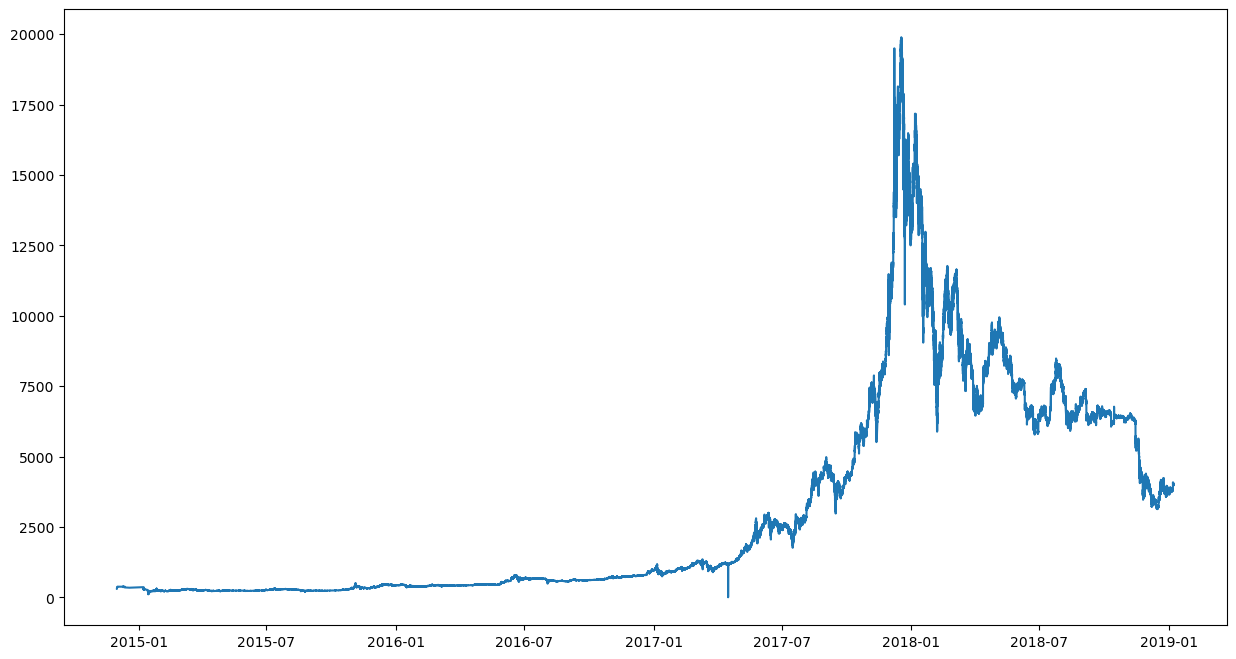

In [26]:
plt.figure(figsize=(15,8))
plt.plot(df.index, df.Close)

In [27]:
df.describe()

,Close
count,2.099760e+06
mean,3.106711e+03
std,3.756936e+03
min,6.000000e-02
25%,4.065000e+02
50%,9.041200e+02
75%,6.216000e+03
max,1.989199e+04


In [28]:
df = df.resample("5T").mean()
df.dropna(inplace=True)
df

,Close
Timestamp,
2014-12-01 05:30:00,300.000
2014-12-01 05:35:00,300.000
2014-12-01 05:40:00,300.000
2014-12-01 05:45:00,300.000
2014-12-01 05:50:00,300.000
...,...
2019-01-07 21:45:00,4015.590
2019-01-07 21:50:00,4010.948
2019-01-07 21:55:00,4007.380


In [29]:
df["Date"] = df.index.date
n_periods = df.pivot_table(index= ["Date"], aggfunc= "size").values        #how many data per day
stats.describe(n_periods)

DescribeResult(nobs=1465, minmax=(1, 288), mean=286.661433447099, variance=336.6298299110388, skewness=-14.954382925131725, kurtosis=226.05813673541272)

In [30]:
df.loc[df["Date"] != df["Date"].shift(), "PerDay"]  = n_periods
df.fillna(method = 'ffill', inplace = True)

df["Ret"] = np.where(df["Date"] == df["Date"].shift(), np.square((df["Close"]-df["Close"].shift()) * 1/df["PerDay"]), np.nan)
df

,Close,Date,PerDay,Ret
Timestamp,,,,
2014-12-01 05:30:00,300.000,2014-12-01,222.0,NaN
2014-12-01 05:35:00,300.000,2014-12-01,222.0,0.000000e+00
2014-12-01 05:40:00,300.000,2014-12-01,222.0,0.000000e+00
2014-12-01 05:45:00,300.000,2014-12-01,222.0,0.000000e+00
2014-12-01 05:50:00,300.000,2014-12-01,222.0,0.000000e+00
...,...,...,...,...
2019-01-07 21:45:00,4015.590,2019-01-07,266.0,4.889479e-07
2019-01-07 21:50:00,4010.948,2019-01-07,266.0,3.045419e-04
2019-01-07 21:55:00,4007.380,2019-01-07,266.0,1.799229e-04


In [31]:
rv = df.groupby("Date")["Ret"].agg(np.sum)
rv = rv.to_frame()
rv

,Ret
Date,
2014-12-01,0.067608
2014-12-02,0.000410
2014-12-03,0.000020
2014-12-04,0.000105
2014-12-06,0.000000
...,...
2019-01-03,0.048973
2019-01-04,0.049550
2019-01-05,0.050929


In [32]:
rv.columns = ["RV_Daily"]
rv["RV_Daily"] = np.sqrt(rv["RV_Daily"])
rv

,RV_Daily
Date,
2014-12-01,0.260016
2014-12-02,0.020246
2014-12-03,0.004478
2014-12-04,0.010227
2014-12-06,0.000000
...,...
2019-01-03,0.221298
2019-01-04,0.222597
2019-01-05,0.225675


In [34]:
rv["RV_weekly"] = rv["RV_Daily"].rolling(7).mean()
rv["RV_monthly"] = rv["RV_Daily"].rolling(30).mean()
rv.dropna(inplace = True)
rv

,RV_Daily,RV_weekly,RV_monthly
Date,,,
2015-02-02,0.036308,0.045475,0.194617
2015-02-03,0.038623,0.041515,0.187237
2015-02-04,0.033455,0.037290,0.187678
2015-02-05,0.034828,0.035352,0.188689
2015-02-06,0.026902,0.033960,0.189245
...,...,...,...
2019-01-03,0.221298,0.400644,0.457511
2019-01-04,0.222597,0.336242,0.449968
2019-01-05,0.225675,0.281976,0.434444


In [35]:
print("p-value of daily RV  :",adf(rv["RV_Daily"].values)[1])
print("p-value of weekly RV :",adf(rv["RV_weekly"].values)[1])
print("p-value of monthly RV:",adf(rv["RV_monthly"].values)[1])

p-value of daily RV  : 0.16928770504624124
p-value of weekly RV : 0.07165499783477113
p-value of monthly RV: 0.04898781975323325


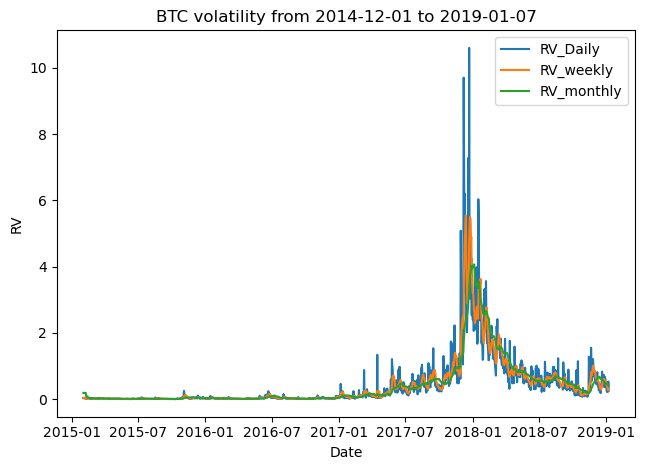

In [36]:
rv[["RV_Daily","RV_weekly","RV_monthly"]].plot(title = f"BTC volatility from {df.index.date[0]} to {df.index.date[-1]}")
plt.tight_layout()
plt.ylabel("RV")
plt.show()

In [37]:
rv["Target"] = rv["RV_Daily"].shift(-1)             #aim to predict next day
rv.dropna(inplace = True)

X = rv.drop(columns=["Target"])
y = rv.Target

In [38]:
X

,RV_Daily,RV_weekly,RV_monthly
Date,,,
2015-02-02,0.036308,0.045475,0.194617
2015-02-03,0.038623,0.041515,0.187237
2015-02-04,0.033455,0.037290,0.187678
2015-02-05,0.034828,0.035352,0.188689
2015-02-06,0.026902,0.033960,0.189245
...,...,...,...
2019-01-02,0.234590,0.433853,0.466128
2019-01-03,0.221298,0.400644,0.457511
2019-01-04,0.222597,0.336242,0.449968


In [39]:
y

Date
2015-02-02    0.038623
2015-02-03    0.033455
2015-02-04    0.034828
2015-02-05    0.026902
2015-02-06    0.020420
                ...   
2019-01-02    0.221298
2019-01-03    0.222597
2019-01-04    0.225675
2019-01-05    0.534852
2019-01-06    0.259766
Name: Target, Length: 1435, dtype: float64

In [40]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 3)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [41]:
print("Shape of X train:    ", X_train.shape[0])
print("Shape of X test:     ", X_test.shape[0])
print("Shape of y train:    ", y_train.shape[0])
print("Shape of y test:     ", y_test.shape[0])

Shape of X train:     1077
Shape of X test:      358
Shape of y train:     1077
Shape of y test:      358


In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
input_scaled = scaler.fit(X_train)
X_train_scaled = input_scaled.transform(X_train)
X_test_scaled = input_scaled.transform(X_test)

y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

scaler = MinMaxScaler()
output_scaled = scaler.fit(y_train)
y_train_scaled = output_scaled.transform(y_train)
y_test_scaled = output_scaled.transform(y_test)

In [44]:
rv["Target"] = rv["RV_Daily"].shift(-1)             #aim to predict next day
rv.dropna(inplace = True)


scaler = MinMaxScaler()
rv_scaled = scaler.fit_transform(rv)
rv_scaled = (rv-rv.min())/(rv.max()-rv.min())

#Add constant c
rv_scaled = sm.add_constant(rv_scaled)

#Split train and test sets
split = int(0.60 * rv.shape[0])
X = rv_scaled.drop("Target", axis = 1)
y = rv_scaled[["Target"]]
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [45]:
results = sm.OLS(y_train_scaled, X_train_scaled).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.762
Model:                            OLS   Adj. R-squared (uncentered):              0.761
Method:                 Least Squares   F-statistic:                              1146.
Date:                Wed, 26 Jul 2023   Prob (F-statistic):                        0.00
Time:                        17:26:16   Log-Likelihood:                          1918.8
No. Observations:                1077   AIC:                                     -3832.
Df Residuals:                    1074   BIC:                                     -3817.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4872      0.032     15.153      0.000       0.424       0.550
x2             0.1457      0.029      4.991      0.000       0.088       0.203
x3             0.0879      0.021      4.253      0.000       0.047       0.128
==============================================================================
Omnibus:                     1764.961   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1222614.909
Skew:                          10.162   Prob(JB):                         0.00
Kurtosis:                     166.804   Cond. No.                         7.23
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

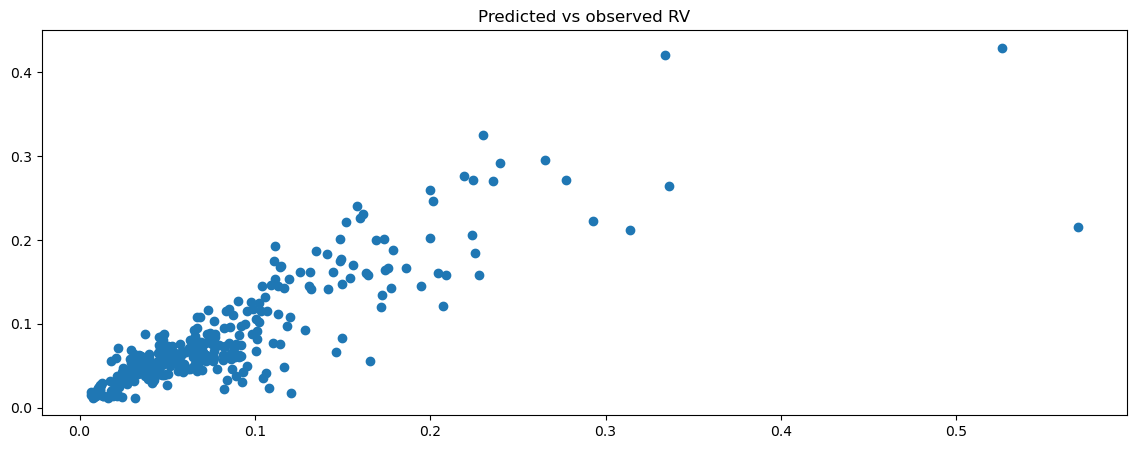

In [46]:
y_hat = results.predict(X_test_scaled)

plt.figure(figsize = (14,5))

plt.scatter(y_test_scaled, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

In [47]:
# Metrics
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [48]:
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train_scaled)
mse_is = score(y_hat_is, y_train_scaled.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train_scaled.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train_scaled.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test_scaled.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test_scaled.ravel(), "R_squared")
mae_oos = score(y_hat, y_test_scaled.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.001659636532583367, R^2:0.7346861341309499, MAE:0.009635800149211943
----------------
Out-of-sample scores
MSE:0.0011876728217674012, R^2:0.7440527591258175, MAE:0.02136414338635282


In [53]:
output_scaled.inverse_transform(y_hat.reshape(-1,1))

array([[2.4513061 ],
       [2.28303179],
       [4.55412369],
       [4.46227823],
       [3.45206532],
       [2.8771938 ],
       [2.86515599],
       [2.88595705],
       [3.13605038],
       [2.92645158],
       [2.55461644],
       [2.15381244],
       [2.34594181],
       [2.04784555],
       [1.77772274],
       [1.70455479],
       [2.13589353],
       [1.95326186],
       [2.24622215],
       [2.7594111 ],
       [2.19246206],
       [2.36278841],
       [2.80240659],
       [3.09222897],
       [2.61329686],
       [2.40511133],
       [2.11834312],
       [2.13386115],
       [1.98971549],
       [1.85196081],
       [1.62589831],
       [1.56996262],
       [1.71383391],
       [1.5409868 ],
       [1.53640572],
       [1.88265946],
       [1.64732731],
       [1.68573156],
       [2.00262288],
       [1.85374106],
       [1.70162831],
       [1.79226556],
       [1.50155334],
       [1.63548561],
       [1.50654497],
       [1.53941856],
       [1.40668485],
       [1.345

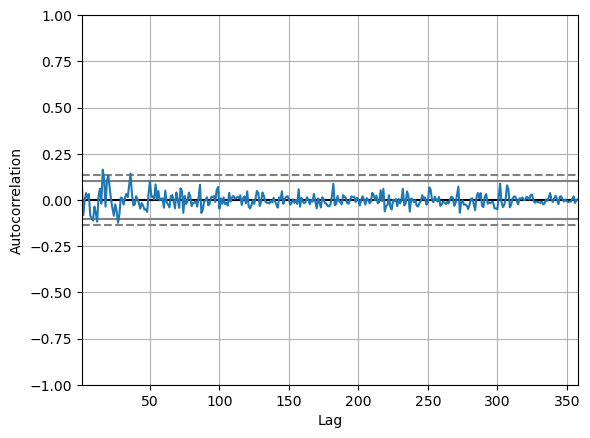

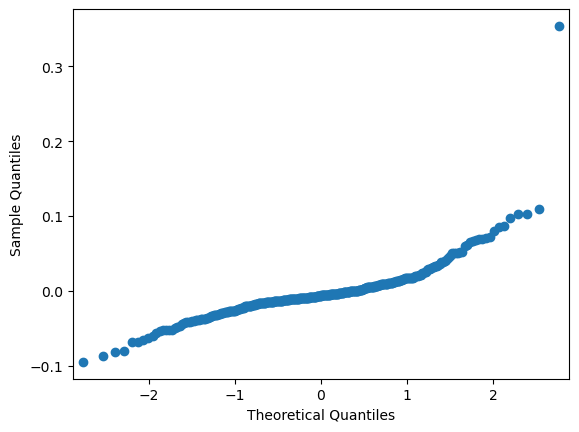

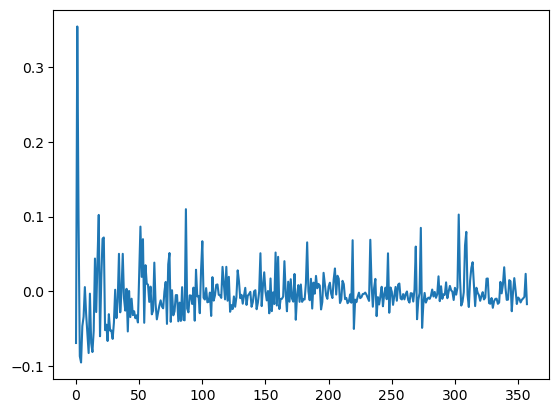

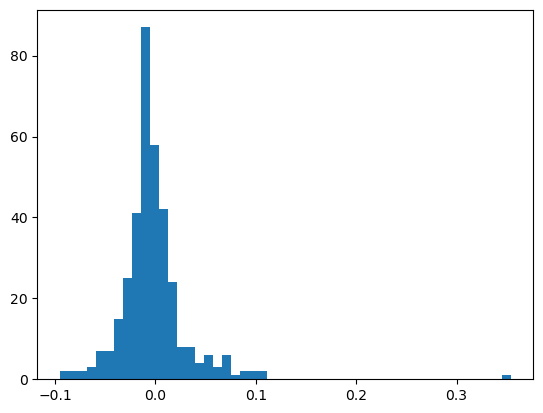

In [49]:
residuals = y_test_scaled.ravel() - y_hat

autocorrelation_plot(residuals);plt.show()
qqplot(residuals);plt.show()
plt.plot(residuals);plt.show()
plt.hist(residuals, bins = 50); plt.show()